**Kate Groschner** <br>
**Homework 7: scikit-image**

## Counting objects

For this problem I followed the outlined procedure. Instead of using the equalize_hist function from the exposure module I used the adaptive histogram equalization because I felt that this yielded better results (image seemed to have better exposure using this method). I also deviated from the suggested procedure by using the remove_small_objects function from the morphology package to help clean small regions of noise. 

In [93]:
%matplotlib inline
from skimage import data
from skimage import io
from skimage import exposure
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure
from skimage import color
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

### 1.0 Import and Display Original Image

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


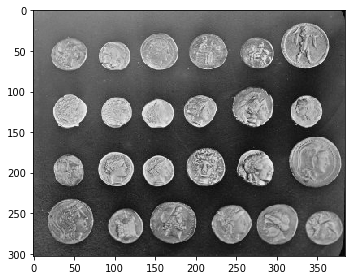

In [94]:
coins = data.coins()
io.imshow(coins)

### 1.1 Equalizing input image
Here I use adaptive histogram equalization because it yields an where the details of the coins can be seen better (as opposed to the original where the coins look very flat). 

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


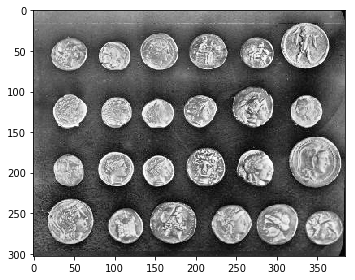

In [120]:
eq_coins = exposure.equalize_adapthist(coins)
io.imshow(eq_coins)

### 1.2 Thresholding using Otsu's Method
Using the threshold calculated by Otsu's method I convert the image to a binary image. Those regions above the threshold get a value of one and those below get a value of zero.

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


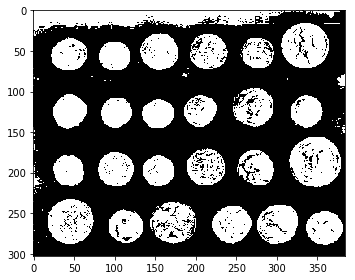

In [121]:
thresh = filters.threshold_otsu(eq_coins)
mask = eq_coins >= thresh
thresh_coins = eq_coins.copy()
thresh_coins[mask]=1
thresh_coins[~mask]=0
io.imshow(thresh_coins)

### 1.3 Segmenting
The clear border segmentation function is used to remove large regions of noise (particularly in the top left corner).

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


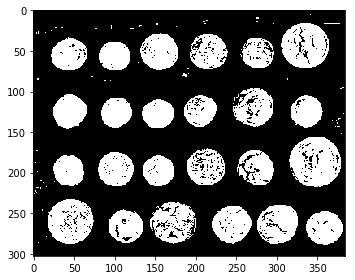

In [122]:
seg_coins = segmentation.clear_border(thresh_coins)
io.imshow(seg_coins)

### 1.4 Morphological closing
Used the closing function from the morphology module. This however left some wholes in the coins so I followed this by two dilation functions to fill in the coin regions. This may make the coins slightly larger than they really are but not doing this led to the coins being too small.

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


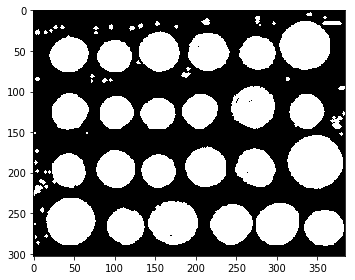

In [123]:
close_coins = morphology.dilation(morphology.dilation(morphology.closing(seg_coins)))
io.imshow(close_coins)

### 1.5 Removing small regions and collecting area and eccentricities
The label function from the measure module is used to label the connected regions. These regions are then plotted (it should be noted that the colors get reused). remove_small_objects function is then used with a specified min size of 1000 to get rid of non-coin regions. Once the image has been cleaned the areas and eccentricities of the coins are measured from the identified regions.

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


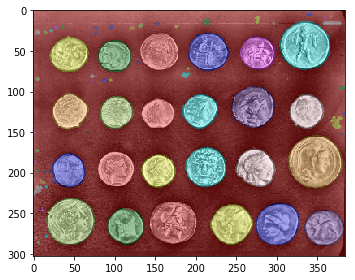

In [127]:
label_coins = measure.label(close_coins)
io.imshow(color.label2rgb(label_coins, image = eq_coins))
cleaned_coins = morphology.remove_small_objects(label_coins, min_size=1000)
coin_regions = measure.regionprops(cleaned_coins,eq_coins)
prop_bbox = []
areas = []
eccentricities = []
for region in coin_regions:
    prop_bbox.append(region.bbox)
    areas.append(region.area)
    eccentricities.append(region.eccentricity)
    

### 1.6 Annotating Image
Finally the image is annotated. A box is put around each identified region and then within this box the area of the region in pixels is labelled (top number) and then the eccentricity is put below this (bottom number).

Text(0.5,1,'Coins Labelled with Area in Pixels(top) followed by Eccentricities(bottom)')

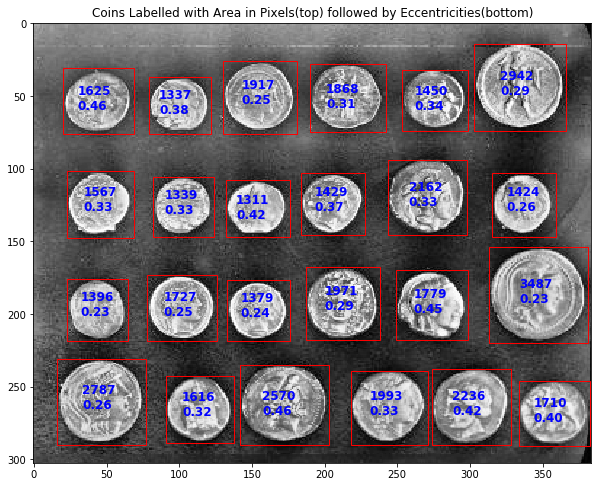

In [125]:
fig, ax = plt.subplots(1,figsize=(10,13))

ax.imshow(eq_coins, cmap='gray')
for idx, bbox in enumerate(prop_bbox):
    width = bbox[3]-bbox[1]
    height = bbox[2]-bbox[0]
    text = str(areas[idx])+'\n'+"{:0.2f}".format(eccentricities[idx])
    len_area = len(str(areas[idx]))
    ax.text(bbox[1]+(height//2)-12,bbox[0]+(width//2)+len_area,text,size = 'large',color='blue',weight = 'semibold')
    rect = patches.Rectangle((bbox[1],bbox[0]),width,height,fill=None,edgecolor = 'red')
    ax.add_patch(rect)
ax.set_title('Coins Labelled with Area in Pixels(top) followed by Eccentricities(bottom)')

## Panorama stitching

For this problem I mostly followed the tutorial given. Much of the code is taken from that however, I decided to make functions out of each of the major steps (importing, finding ORB features, running RANSAC to get rid of bad features, warping the images according to the RANSAC models, generating a mask from cost paths,and then combining into a color image). I found that tinkering with number of ORB keypoints helped the most in terms of hvaing the stitching coming out properly. Increasing or decreasing the threshold for ORB features did not seem to improve results. I had also reduced the size of my images and found that I tended to get better results when the image was kept closer to the original size (which makes intuitive sense). The smaller the image got the worse the minimum cost path turned out. That's why I left the images fairly large (and therefore the pipeline takes a little while to run). The pipeline outputs the original images, the warped images, the minimum cost path overlayed on the images being combined, and the final stitched image. 

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import transform
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.measure import label
from skimage.graph import route_through_array
from skimage.measure import label
from IPython.display import display

In [132]:
def compare(*images, **kwargs):
    """
    Taken as is from the tutorial. Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        image = transform.rescale(image,0.8)
        axes[n].imshow(image)
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

In [133]:
def make_pano_images(directory):
    """
    Function to import images from a directory contianing only those images and output them as 1/4 scale and grayscale
    """
    pano_imgs = io.ImageCollection('/Users/kategroschner/Downloads/bridge/*.JPG')
    img_dir = {}
    for idx, img in enumerate(pano_imgs):
        name ='pano'+str(idx)
        img_dir[name] = rgb2gray(transform.rescale(img,0.8))
    return(pano_imgs,img_dir['pano0'], img_dir['pano1'], img_dir['pano2'])

In [134]:
def feature_finder(pano0,pano1,pano2):
    """
    Function to find ORB keypoints and descriptors and then generate match points betweent the left and center image
    and the center and right image.
    """
    orb = ORB(n_keypoints=1000, fast_threshold=0.05)
    kypts = {}
    # Detect keypoints in pano0
    orb.detect_and_extract(pano0)
    kypts['keypoints0'] = orb.keypoints
    kypts['descriptors0'] = orb.descriptors

    # Detect keypoints in pano1 and pano2
    orb.detect_and_extract(pano1)
    kypts['keypoints1'] = orb.keypoints
    kypts['descriptors1'] = orb.descriptors

    orb.detect_and_extract(pano2)
    kypts['keypoints2'] = orb.keypoints
    kypts['descriptors2'] = orb.descriptors
    
    matches01 = match_descriptors(kypts['descriptors0'], kypts['descriptors1'], cross_check=True)
    matches12 = match_descriptors(kypts['descriptors1'], kypts['descriptors2'], cross_check=True)

    return(kypts, matches01, matches12)

In [135]:
def clean_features(pano0,pano1, pano2):
    """
    Function to run RANSAC to get rid of outliers and find the best matches among the detected ORB features
    """
    kypts, matches01, matches12 = feature_finder(pano0, pano1, pano2)
        # Select keypoints from
    #   * source (image to be registered): pano0
    #   * target (reference image): pano1, our middle frame registration target
    src = kypts['keypoints0'][matches01[:, 0]][:, ::-1]
    dst = kypts['keypoints1'][matches01[:, 1]][:, ::-1]

    model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)

    # Select keypoints from
    #   * source (image to be registered): pano2
    #   * target (reference image): pano1, our middle frame registration target
    src = kypts['keypoints2'][matches12[:, 1]][:, ::-1]
    dst = kypts['keypoints1'][matches12[:, 0]][:, ::-1]

    model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)
    
    return(model_robust01, inliers01,model_robust12, inliers12)

In [136]:
def warp_images(pano0,pano1,pano2, model_robust01, inliers01,model_robust12, inliers12):
    """
    Function to warp images using the ORB features that were found to be most likely to be valid by RANSAC
    """
    # Shape of middle image, our registration target
    r, c = pano1.shape[:2]

    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners01 = model_robust01(corners)
    warped_corners12 = model_robust12(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners01, warped_corners12, corners))

    # The overall output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)

    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    # This in-plane offset is the only necessary transformation for the middle image
    offset1 = SimilarityTransform(translation= -corner_min)

    # Translate pano1 into place
    pano1_warped = warp(pano1, offset1.inverse, order=3,
                        output_shape=output_shape, cval=-1)

    # Acquire the image mask for later use
    pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
    pano1_warped[~pano1_mask] = 0      # Return background values to 0
    # Warp pano0 to pano1
    transform01 = (model_robust01 + offset1).inverse
    pano0_warped = warp(pano0, transform01, order=3,
                        output_shape=output_shape, cval=-1)

    pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
    pano0_warped[~pano0_mask] = 0      # Return background values to 0
    # Warp pano2 to pano1
    transform12 = (model_robust12 + offset1).inverse
    pano2_warped = warp(pano2, transform12, order=3,
                        output_shape=output_shape, cval=-1)

    pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
    pano2_warped[~pano2_mask] = 0      # Return background values to 0
    return(output_shape,offset1, pano0_warped,pano1_warped,pano2_warped, pano0_mask, pano1_mask,pano2_mask)

In [137]:
def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Taken directly from the tutorial as is. Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : (M, N) ndarray of floats
        Difference of two overlapping images.
    mask : (M, N) ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : (M, N) ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

In [151]:
def mask_maker(output_shape,offset1, pano0_warped,pano1_warped,pano2_warped, pano0_mask, pano1_mask,pano2_mask):
    """
    Function that takes the warped pan images and calculates the minimum cost path using
    a cost array that is initialized with seed points. Function calls generate_costs to determine
    minimum cost path. This minimum cost path is then used to cut the warped images so that they
    can then be stitched together along the lines calculated. Outputs a mask for each image.
    """
    ymax = output_shape[1] - 1
    xmax = output_shape[0] - 1

    # Start anywhere along the top and bottom, left of center.
    mask_pts01 = [[0,    ymax // 3],
                  [xmax, ymax // 3]]

    # Start anywhere along the top and bottom, right of center.
    mask_pts12 = [[0,    2*ymax // 3],
                  [xmax, 2*ymax // 3]]
    costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)
    costs01[0, :] = 0
    costs01[-1, :] = 0
    pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)
    pts = np.array(pts)
    
    #plot 1
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the difference image
    ax.imshow(pano0_warped - pano1_warped, cmap='gray')
    ax.set_title('Cost Path for Pano0 and Pano1')

    # Overlay the minimum-cost path
    ax.plot(pts[:, 1], pts[:, 0])  
    plt.tight_layout()
    ax.axis('off');

    # Start with an array of zeros and place the path
    mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
    mask0[pts[:, 0], pts[:, 1]] = 1
    mask0 = (label(mask0, connectivity=1, background=-1) == 1)
    # Start with the absolute value of the difference image.
    # np.abs is necessary because we don't want negative costs!
    costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                             pano1_mask & pano2_mask)

    # Allow the path to "slide" along top and bottom edges to the optimal 
    # horizontal position by setting top and bottom edges to zero cost
    costs12[0,  :] = 0
    costs12[-1, :] = 0
    costs12[mask0 > 0] = 1
    pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)
    pts = np.array(pts)
    
    #plot2
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the difference image
    ax.imshow(pano1_warped - pano2_warped, cmap='gray')
    ax.set_title('Cost Path for Pano1 and Pano2')

    # Overlay the minimum-cost path
    ax.plot(pts[:, 1], pts[:, 0]);
    ax.axis('off');

    # Convert list of lists to 2d coordinate array for easier indexing
    
    mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
    mask2[pts[:, 0], pts[:, 1]] = 1
    mask2 = (label(mask2, connectivity=1, background=-1) == 3)
    mask1 = ~(mask0 | mask2).astype(bool)
    return(mask0,mask1,mask2)

In [139]:
def add_alpha(img, mask=None):
    """
    Taken directly from tutorial as is. Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

In [153]:
def combine_images(pano_imgs,model_robust01,model_robust12,output_shape,offset1, mask0, mask1, mask2):
    """
    Function using the orginal color images, the warping models calculated by RANSAC, 
    and the masks made using the minimum cost function the images are warped, cut,
    and then stitched together. Outputs the final stitched image.
    """

    pano0_color = warp(transform.rescale(pano_imgs[0],0.8), \
                       (model_robust01 + offset1).inverse, order=3,
                       output_shape=output_shape, cval=0)

    pano1_color = warp(transform.rescale(pano_imgs[1],0.8), offset1.inverse, order=3,
                       output_shape=output_shape, cval=0)

    pano2_color = warp(transform.rescale(pano_imgs[2],0.8),\
                       (model_robust12 + offset1).inverse, order=3,
                       output_shape=output_shape, cval=0)
    pano0_final = add_alpha(pano0_color, mask0)
    pano1_final = add_alpha(pano1_color, mask1)
    pano2_final = add_alpha(pano2_color, mask2)
    fig, ax = plt.subplots(figsize=(12, 12))

    # Turn off matplotlib's interpolation
    ax.imshow(pano0_final, interpolation='none')
    ax.imshow(pano1_final, interpolation='none')
    ax.imshow(pano2_final, interpolation='none')

    fig.tight_layout()
    ax.axis('off');

In [154]:
def stitching_pipeline(directory):
    """
    Combines all the previously defined functions to output the 
    original images, the warped images, the minimum cost path,
    and the final stitched image.
    """
    pano_imgs, pano0, pano1, pano2 = make_pano_images(directory)
    compare(*pano_imgs,figsize = (12,10))
    plt.gcf().title('Original Images')
    features = clean_features(pano0,pano1, pano2)
    warps_masks = warp_images(pano0,pano1, pano2,*features)
    compare(warps_masks[2], warps_masks[3], warps_masks[4], figsize=(12, 10));
    plt.gcf().title('Warped Pano0, Pano1, and Pano2')
    mask0,mask1,mask2 = mask_maker(*warps_masks)
    combine_images(pano_imgs,features[0],features[2],warps_masks[0],warps_masks[1], mask0, mask1, mask2)
    plt.gcf().title('Stitched Together Panorama')

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


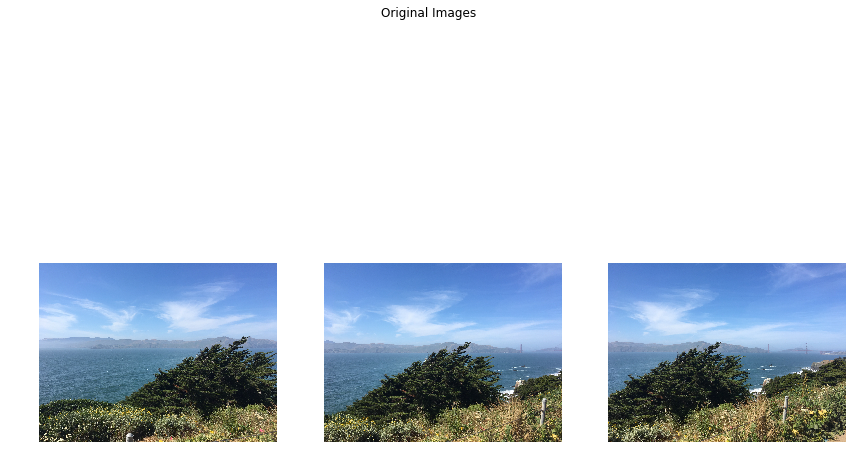

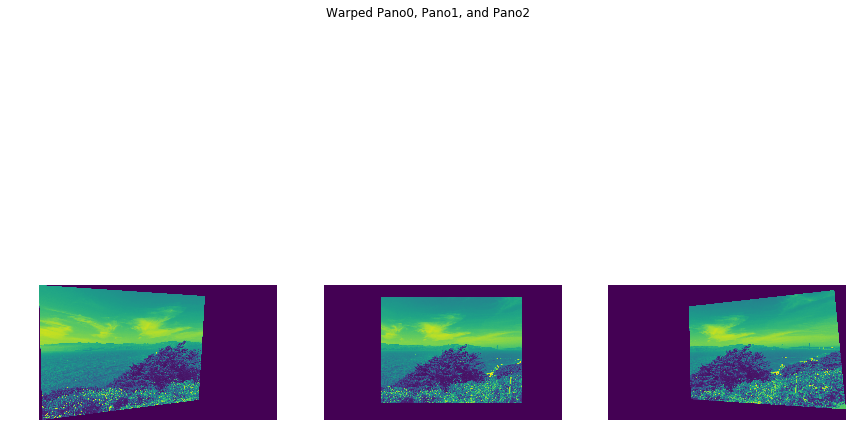

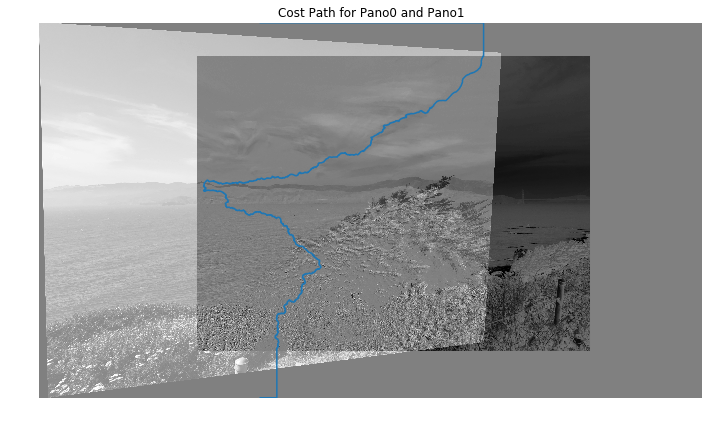

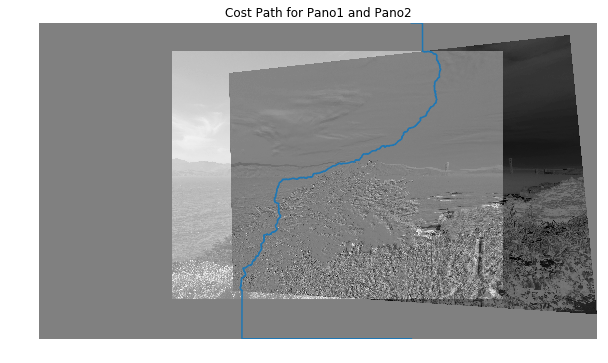

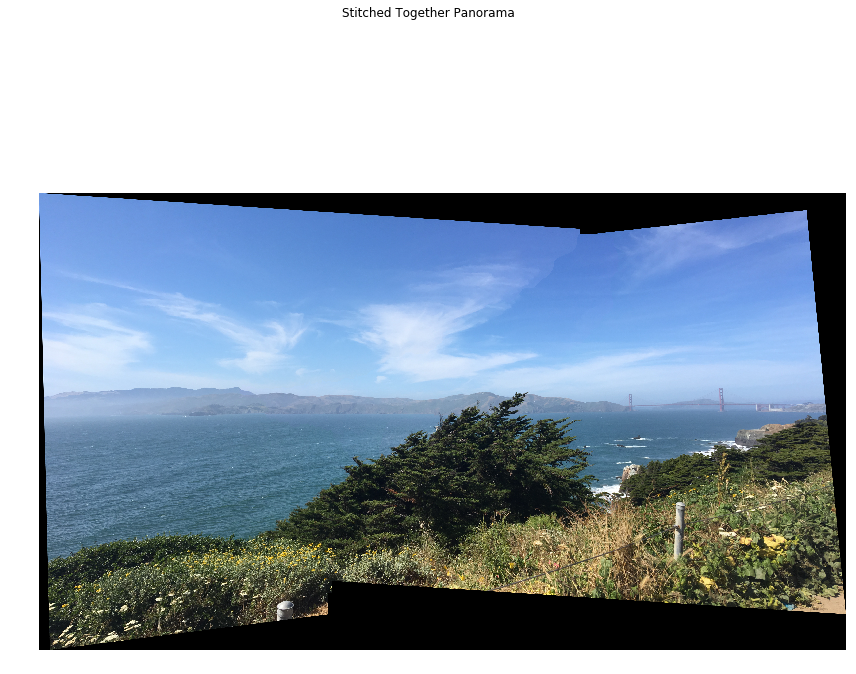

In [148]:
directory = 'bridge/*.JPG'
stitching_pipeline(directory)

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.

In [77]:
%matplotlib inline
import rawpy
from pathlib import Path
from os.path import abspath
from skimage import img_as_float, io, exposure
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import rescale
from skimage import exposure

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


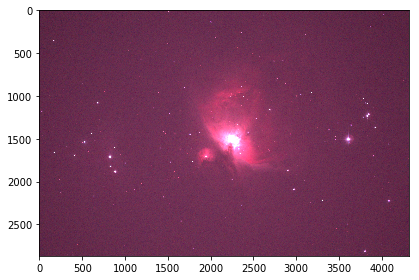

In [41]:
path = '/Users/kategroschner/Downloads/M42_03_09_2013/Lights/Lights6.NEF'
raw = rawpy.imread(path)
rgb = raw.postprocess()
io.imshow(rgb)

In [50]:
path = '/Users/kategroschner/Downloads/M42_03_09_2013/'
files = list(Path(path).glob('*/*.NEF'))
for file in files:
    file_in = abspath(file)
    raw = rawpy.imread(file_in)
    rgb = raw.postprocess()
    name = file_in.split('.')[0]+'.png'
    io.imsave(name,rgb)
print('done!')

done!


In [6]:
path = '/Users/kategroschner/Downloads/M42_03_09_2013/'
lights = io.ImageCollection(path+'Lights/*.png')
flats = io.ImageCollection(path+'Flats/*.png')
darks = io.ImageCollection(path+'Darks/*.png')
dark_flats = io.ImageCollection(path+'Dark Flats/*.png')

In [64]:
#divide dark flats from darks
#divide flats from lights
#subtract darks from lights


def dark_flat_median(dark_flats):
    df_list = np.array([rgb2gray(img_as_float(rescale(img,0.7))) for img in dark_flats])
    df_med = np.median(df_list, axis=0)
    return(df_med)
def dark_stack(darks,df_med):
    dk_list = np.array([np.divide(rgb2gray(img_as_float(rescale(img,0.7))),df_med) for img in darks])
    dark_med = np.median(dk_list, axis = 0)
    return(dark_med)

In [30]:
df_med = dark_flat_median(dark_flats)

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [51]:
for index in np.argwhere(df_med == 0):
    df_med[index[0],index[1]] = 0.00000001

In [53]:
np.argwhere(df_med == 0)

array([], shape=(0, 2), dtype=int64)

In [65]:
dark_med = dark_stack(darks,df_med)

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [75]:
dark_max_loc =np.argwhere(dark_med == dark_med.max())
dark_med[dark_max_loc[0,0],dark_max_loc[0,1]] = dark_med.mean()

In [86]:
lght_med = dark_flat_median(flats)

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [88]:
light_med = dark_stack(lights,lght_med)

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [90]:
cleaned_light = light_med - dark_med

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


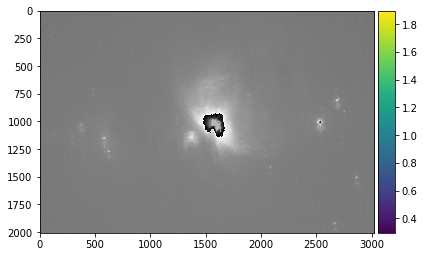

In [92]:
io.imshow(gray2rgb(light_med))

This turned out poorly. 